# Algorithmic Trading Model using Stochastic RSI with Different Signal Levels
### David Lowe
### September 15, 2021

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This algorithmic trading model employs a simple mean-reversion strategy using the Stochastic RSI (StochRSI) indicators for stock position entries and exits. For the Stochastic RSI indicator, the model will use a 14 look-back period. The model will initiate a long position when the indicator crosses the lower signal line from above. Conversely, the model will exit the long position when the indicator crosses the upper signal line from below.

ANALYSIS: In this modeling iteration, we analyzed ten stocks between August 1, 2016, and September 10, 2021. The models' performance appeared at the end of the script. The models with the wider signal line width generally produced a better return for the tested stocks. Moreover, the simple buy-and-hold approach came out ahead for all stocks.

CONCLUSION: For most stocks during the modeling time frame, the long-only trading strategy with the Stochastic RSI signals did not produce a better return than the buy-and-hold approach. We should consider modeling these stocks further by experimenting with more variations of the strategy.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Implement and Train Models
4. Back-test Models
5. Evaluate Strategy Performance

## Task 1 - Prepare Environment

### 1.a) Load libraries and modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import sys
from datetime import date, datetime, timedelta
import requests
import json
import statistics as stats
from dotenv import load_dotenv

# Begin the timer for the script processing
startTimeScript = datetime.now()

In [2]:
# # Set up access to the dotenv file on local PC
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

### 1.b) Set up the controlling parameters and functions¶

In [3]:
# Specify the key modeling parameters below
stock_list = ['ABBV','AMD','AMZN','BA','DIS','NFLX','GOOGL','JPM','MSFT','LUV']

# Specify the parameters for calculating moving average windows
# TREND_WINDOW = 20
VOLUME_WINDOW = 5
MEAN_REVERSION = True  # If false, model using the trend-following strategy

# Specify the parameters for calculating Stochastic Oscillator
LOOKBACK_PERIOD = 14

# Specify the modeling thresholds
MODEL_1_UPPER = 80
MODEL_1_LOWER = 20
MODEL_2_UPPER = 70
MODEL_2_LOWER = 30

# Specify the risk management parameters
HOLDING_PERIOD_MIN = 999
HOLDING_PERIOD_MAX = 999
GAIN_MAX = 0.99
LOSS_MAX = 0.99
LONG_ONLY = True  # If false, model both long and short trades

# The number of extra days of data we need for calculating moving averages (usually equals to the largest value of window size)
EXTRA_DAYS = 30

MODEL_START_DATE = date(2019, 8, 1)
print("Starting date for the model:", MODEL_START_DATE)

# MODEL_END_DATE = datetime.now().date()
MODEL_END_DATE = date(2021, 9, 10)
print("Ending date for the model:", MODEL_END_DATE)

# data_start_date = MODEL_START_DATE
data_start_date = MODEL_START_DATE - timedelta(days=int(EXTRA_DAYS * 2)) # Need more pricing data to calculate moving averages
print("First date of data we need for modeling:", data_start_date)

data_end_date = MODEL_END_DATE
print("Last date of data we need for modeling:", data_end_date)

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose_data_retrieval = False  # Show the head and tail of the raw dataframe
verbose_indicators = False  # All entries from the Indicators dataframe
verbose_signals = False  # All entries from the Signals dataframe
verbose_entry_exit = False  # All entry and exit points from the Signals dataframe
verbose_trade_actions = False  # All bought and sold activities during portfolio generation
verbose_portfolios = False  # All entries from the Positions dataframe
verbose_transactions = False  #  All buying and selling transactions from the Positions dataframe
verbose_draw_graphs = True

Starting date for the model: 2019-08-01
Ending date for the model: 2021-09-10
First date of data we need for modeling: 2019-06-02
Last date of data we need for modeling: 2021-09-10


In [4]:
# Set up parameters for displaying report data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 999)
pd.set_option('display.float_format', '{:.4f}'.format)

## Task 2 - Acquire and Pre-Process Data

In [5]:
def retrieve_stock_data(ticker=stock_list[0]):
    # Set up the data service provider and data acquisition parameters
    data_service = 'Quandl'

    # Check and see whether the API key is available
    api_key = os.environ.get('QUANDL_API')
    if api_key is None: sys.exit(data_service + ' API key not available. Script processing cannot continue!!!')

    if ticker=='': sys.exit('Stock symbol not available. Script processing cannot continue!!!')

    start_date_string = data_start_date.strftime('%Y-%m-%d')
    end_date_string = data_end_date.strftime('%Y-%m-%d')
    api_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, ticker, api_key)
    response = requests.get(api_url)
    resp_dict = json.loads(response.text)
    stock_rawdata = pd.DataFrame(resp_dict['datatable']['data'])
    print(len(stock_rawdata), 'data points retrieved from the API call for stock:', ticker)

    stock_rawdata.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'closeadj', 'closeunadj', 'lastupdated']
    stock_rawdata['openadj'] = stock_rawdata['open'] * (stock_rawdata['closeadj'] / stock_rawdata['closeunadj'])
    stock_rawdata['highadj'] = stock_rawdata['high'] * (stock_rawdata['closeadj'] / stock_rawdata['closeunadj'])
    stock_rawdata['lowadj'] = stock_rawdata['low'] * (stock_rawdata['closeadj'] / stock_rawdata['closeunadj'])
    # stock_rawdata.set_index('date', inplace=True)
    stock_rawdata.index = pd.to_datetime(stock_rawdata.date)
    stock_pricing = stock_rawdata.sort_index(ascending=True)

    # Set up the standard column name for modeling
    # Column names may be data-provider specific!
    model_template = stock_pricing.loc[:, ['openadj','highadj','lowadj','closeadj','volume']]
    model_template.rename(columns={'openadj': 'open_price', 'highadj': 'high_price',
                                   'lowadj': 'low_price', 'closeadj': 'close_price',
                                   'volume': 'trading_volume'}, inplace=True)
    if verbose_data_retrieval:
        print(model_template.head())
        print()
        print(model_template.tail())

    return model_template

## Task 3 - Implement and Train Models

In [6]:
def populate_indicators(model_template):
    """
    Calculate and populate the model template with the required indicators
    """

    indicators_model = model_template.copy()
    volume_window = VOLUME_WINDOW
    lookback_period = LOOKBACK_PERIOD

    indicators_model['volume_ma'] = indicators_model['trading_volume'].rolling(volume_window).mean()

    # Calculate the RSI ratings
    gain_history = []
    loss_history = []
    for k in range(len(indicators_model)):
        close_price = indicators_model.at[indicators_model.index[k],'close_price']
        if k == 0:
            indicators_model.at[indicators_model.index[k],'rsi_value'] = 50
        else:
            previous_price = indicators_model.at[indicators_model.index[k-1],'close_price']
            gain_history.append(max(0, close_price - previous_price))
            loss_history.append(max(0, previous_price - close_price))
            if len(gain_history) > lookback_period: # maximum observations is equal to look-back period
                del (gain_history[0])
                del (loss_history[0])
            avg_gain = stats.mean(gain_history) # average gain over look-back period
            avg_loss = stats.mean(loss_history) # average loss over look-back period
            rs = 1
            if avg_loss > 0: # to avoid division by 0, which is undefined
                rs = avg_gain / avg_loss
            indicators_model.at[indicators_model.index[k],'rsi_value'] = 100 - (100 / (1 + rs))

    indicators_model['highest_high'] = indicators_model['rsi_value'].rolling(lookback_period).max()
    indicators_model['lowest_low'] = indicators_model['rsi_value'].rolling(lookback_period).min()
    indicators_model['stoch_rsi'] = (indicators_model['rsi_value'] - indicators_model['lowest_low']) / (indicators_model['highest_high'] - indicators_model['lowest_low']) * 100

    indicators_model['buy_on_open'] = False
    indicators_model['sell_on_open'] = False
    indicators_model['short_on_open'] = False
    indicators_model['cover_on_open'] = False
    indicators_model['position_long'] = False
    indicators_model['position_short'] = False
    indicators_model['holding_period'] = 0
    indicators_model['cost_basis'] = 0.0
    indicators_model['gain_loss_pct'] = 0.0

    # Truncate the model to the required starting and ending dates
    indicators_model = indicators_model[MODEL_START_DATE:MODEL_END_DATE]

    if verbose_indicators: print(indicators_model, '\n')
    return indicators_model

In [7]:
# Define the function that will generate the indicators and trading signals
# General logic for processing the trading signals for each time period
# 1 - Check to see whether we need to execute a trading action from the previous day's signal. Once the trading action is executed, move on to the next day.
# 2 - If no trade actions to execute on open, check to see whether we have any breakout that generates a trading signal. If we have a new trading signal and currently has no position, mark the entry action for the next day.
# 3 - If no new signal for today, check to see whether we need to exit any existing position. If we have an exit signal and currently hold a position, mark the exit action for the next day.
# 4 - If nothing is going on, mark up the trading model appropriately and move to the next day.

def populate_signals_model1(indicators_model):
    """
    Calculate signals for a Mean Reversion strategy
    Entry signals -- StochRSI line crosses over the lower signal line from above
    Exit signals -- StochRSI line crosses over the upper signal line from below
    """

    trade_model = indicators_model.copy()
    mean_reversion_flag = MEAN_REVERSION
    last_index = len(trade_model) - 1
    upper_threshold = MODEL_1_UPPER
    lower_threshold = MODEL_1_LOWER

    for k in range(len(trade_model)-1):
        # Calculate the breakout, True or False.
        price_today = trade_model.at[trade_model.index[k],'close_price']
        signal_line = trade_model.at[trade_model.index[k],'stoch_rsi']
        if k > 0:
            signal_previous = trade_model.at[trade_model.index[k-1],'stoch_rsi']
        else:
            signal_previous = 0  # When k is at 0, no previous signal to compare
        if mean_reversion_flag:
            breakout_long_side = (signal_previous > lower_threshold) and (signal_line < lower_threshold)
            breakout_short_side = (signal_previous < upper_threshold) and (signal_line > upper_threshold)
        else:
            breakout_long_side = (signal_previous < upper_threshold) and (signal_line > upper_threshold)
            breakout_short_side = (signal_previous > lower_threshold) and (signal_line < lower_threshold)
        volume_today = trade_model.at[trade_model.index[k],'trading_volume']
        volume_avg = trade_model.at[trade_model.index[k],'volume_ma']

        # Set the exit signals
        exit_long_position = breakout_short_side
        exit_short_position = breakout_long_side

        # For the very first trading session, just need to check for the breakout action
        if k == 0:
            if breakout_long_side and (volume_today > volume_avg):
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif breakout_short_side and (volume_today > volume_avg) and (not LONG_ONLY):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True
        else:
            currently_long = trade_model.at[trade_model.index[k-1],'position_long']
            currently_short = trade_model.at[trade_model.index[k-1],'position_short']
            holding_period = trade_model.at[trade_model.index[k-1],'holding_period']
            cost_basis = trade_model.at[trade_model.index[k-1],'cost_basis']

            # Check to see whether we need to execute any trade action on open
            if trade_model.at[trade_model.index[k],'buy_on_open']:
                trade_executed_today = True
                currently_long = True
                currently_short = False
                holding_period = 1
                cost_basis = -trade_model.at[trade_model.index[k],'open_price']
            elif trade_model.at[trade_model.index[k],'short_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = True
                holding_period = 1
                cost_basis = trade_model.at[trade_model.index[k],'open_price']
            elif trade_model.at[trade_model.index[k],'sell_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = False
                holding_period = 0
                cost_basis = 0.0
            elif trade_model.at[trade_model.index[k],'cover_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = False
                holding_period = 0
                cost_basis = 0.0
            else:
                trade_executed_today = False

            # If no trade on open, check to see whether we have a breakout with an entry the next day
            if breakout_long_side and (not currently_long) and (not currently_short) and (volume_today > volume_avg) and (k < last_index):
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif breakout_short_side and (not currently_long) and (not currently_short) and (volume_today > volume_avg) and (k < last_index) and (not LONG_ONLY):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True

            # If no breakout, check to see whether we need to exit based on the price action
            if currently_long and (exit_long_position or (holding_period >= HOLDING_PERIOD_MAX)):
                trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            elif currently_short and (exit_short_position or (holding_period >= HOLDING_PERIOD_MAX)):
                trade_model.at[trade_model.index[k+1],'cover_on_open'] = True

            # If no breakout, check to see whether we need to exit based on the profit or loss targets
            if currently_long :
                up_down_pct = (cost_basis + price_today) / abs(cost_basis)
                trade_model.at[trade_model.index[k],'gain_loss_pct'] = up_down_pct
                if (up_down_pct >= GAIN_MAX) or (up_down_pct <= -LOSS_MAX) :
                    trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            elif currently_short :
                up_down_pct = (cost_basis - price_today) / abs(cost_basis)
                trade_model.at[trade_model.index[k],'gain_loss_pct'] = up_down_pct
                if (up_down_pct >= GAIN_MAX) or (up_down_pct <= -LOSS_MAX) :
                    trade_model.at[trade_model.index[k+1],'cover_on_open'] = True

            # If no action on a given day, carry over the position status
            if (k > 0) and (not trade_executed_today):
                if currently_long or currently_short:
                    holding_period = holding_period + 1

            trade_model.at[trade_model.index[k],'position_long'] = currently_long
            trade_model.at[trade_model.index[k],'position_short'] = currently_short
            trade_model.at[trade_model.index[k],'holding_period'] = holding_period
            trade_model.at[trade_model.index[k],'cost_basis'] = cost_basis

            # # Exiting the position on the last day of modeling period
            # if k == last_index-1:
            #     if trade_model.at[trade_model.index[k],'position_long']:
            #         trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            #         trade_model.at[trade_model.index[k+1],'position_long'] = False
            #     elif trade_model.at[trade_model.index[k],'position_short']:
            #         trade_model.at[trade_model.index[k+1],'cover_on_open'] = True
            #         trade_model.at[trade_model.index[k+1],'position_short'] = False

    if verbose_signals: print(trade_model, '\n')
    return trade_model

In [8]:
# Define the function that will generate the indicators and trading signals
# General logic for processing the trading signals for each time period
# 1 - Check to see whether we need to execute a trading action from the previous day's signal. Once the trading action is executed, move on to the next day.
# 2 - If no trade actions to execute on open, check to see whether we have any breakout that generates a trading signal. If we have a new trading signal and currently has no position, mark the entry action for the next day.
# 3 - If no new signal for today, check to see whether we need to exit any existing position. If we have an exit signal and currently hold a position, mark the exit action for the next day.
# 4 - If nothing is going on, mark up the trading model appropriately and move to the next day.

def populate_signals_model2(indicators_model):
    """
    Calculate signals for a Mean Reversion strategy
    Entry signals -- StochRSI line crosses over the lower signal line from above
    Exit signals -- StochRSI line crosses over the upper signal line from below
    """

    trade_model = indicators_model.copy()
    mean_reversion_flag = MEAN_REVERSION
    last_index = len(trade_model) - 1
    upper_threshold = MODEL_2_UPPER
    lower_threshold = MODEL_2_LOWER

    for k in range(len(trade_model)-1):
        # Calculate the breakout, True or False.
        price_today = trade_model.at[trade_model.index[k],'close_price']
        signal_line = trade_model.at[trade_model.index[k],'stoch_rsi']
        if k > 0:
            signal_previous = trade_model.at[trade_model.index[k-1],'stoch_rsi']
        else:
            signal_previous = 0  # When k is at 0, no previous signal to compare
        if mean_reversion_flag:
            breakout_long_side = (signal_previous > lower_threshold) and (signal_line < lower_threshold)
            breakout_short_side = (signal_previous < upper_threshold) and (signal_line > upper_threshold)
        else:
            breakout_long_side = (signal_previous < upper_threshold) and (signal_line > upper_threshold)
            breakout_short_side = (signal_previous > lower_threshold) and (signal_line < lower_threshold)
        volume_today = trade_model.at[trade_model.index[k],'trading_volume']
        volume_avg = trade_model.at[trade_model.index[k],'volume_ma']

        # Set the exit signals
        exit_long_position = breakout_short_side
        exit_short_position = breakout_long_side

        # For the very first trading session, just need to check for the breakout action
        if k == 0:
            if breakout_long_side and (volume_today > volume_avg):
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif breakout_short_side and (volume_today > volume_avg) and (not LONG_ONLY):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True
        else:
            currently_long = trade_model.at[trade_model.index[k-1],'position_long']
            currently_short = trade_model.at[trade_model.index[k-1],'position_short']
            holding_period = trade_model.at[trade_model.index[k-1],'holding_period']
            cost_basis = trade_model.at[trade_model.index[k-1],'cost_basis']

            # Check to see whether we need to execute any trade action on open
            if trade_model.at[trade_model.index[k],'buy_on_open']:
                trade_executed_today = True
                currently_long = True
                currently_short = False
                holding_period = 1
                cost_basis = -trade_model.at[trade_model.index[k],'open_price']
            elif trade_model.at[trade_model.index[k],'short_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = True
                holding_period = 1
                cost_basis = trade_model.at[trade_model.index[k],'open_price']
            elif trade_model.at[trade_model.index[k],'sell_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = False
                holding_period = 0
                cost_basis = 0.0
            elif trade_model.at[trade_model.index[k],'cover_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = False
                holding_period = 0
                cost_basis = 0.0
            else:
                trade_executed_today = False

            # If no trade on open, check to see whether we have a breakout with an entry the next day
            if breakout_long_side and (not currently_long) and (not currently_short) and (volume_today > volume_avg) and (k < last_index):
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif breakout_short_side and (not currently_long) and (not currently_short) and (volume_today > volume_avg) and (k < last_index) and (not LONG_ONLY):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True

            # If no breakout, check to see whether we need to exit based on the price action
            if currently_long and (exit_long_position or (holding_period >= HOLDING_PERIOD_MAX)):
                trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            elif currently_short and (exit_short_position or (holding_period >= HOLDING_PERIOD_MAX)):
                trade_model.at[trade_model.index[k+1],'cover_on_open'] = True

            # If no breakout, check to see whether we need to exit based on the profit or loss targets
            if currently_long :
                up_down_pct = (cost_basis + price_today) / abs(cost_basis)
                trade_model.at[trade_model.index[k],'gain_loss_pct'] = up_down_pct
                if (up_down_pct >= GAIN_MAX) or (up_down_pct <= -LOSS_MAX) :
                    trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            elif currently_short :
                up_down_pct = (cost_basis - price_today) / abs(cost_basis)
                trade_model.at[trade_model.index[k],'gain_loss_pct'] = up_down_pct
                if (up_down_pct >= GAIN_MAX) or (up_down_pct <= -LOSS_MAX) :
                    trade_model.at[trade_model.index[k+1],'cover_on_open'] = True

            # If no action on a given day, carry over the position status
            if (k > 0) and (not trade_executed_today):
                if currently_long or currently_short:
                    holding_period = holding_period + 1

            trade_model.at[trade_model.index[k],'position_long'] = currently_long
            trade_model.at[trade_model.index[k],'position_short'] = currently_short
            trade_model.at[trade_model.index[k],'holding_period'] = holding_period
            trade_model.at[trade_model.index[k],'cost_basis'] = cost_basis

            # # Exiting the position on the last day of modeling period
            # if k == last_index-1:
            #     if trade_model.at[trade_model.index[k],'position_long']:
            #         trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            #         trade_model.at[trade_model.index[k+1],'position_long'] = False
            #     elif trade_model.at[trade_model.index[k],'position_short']:
            #         trade_model.at[trade_model.index[k+1],'cover_on_open'] = True
            #         trade_model.at[trade_model.index[k+1],'position_short'] = False

    if verbose_signals: print(trade_model, '\n')
    return trade_model

In [9]:
# List the entry/exit points for each model
def list_model_entry_exit(trade_model):
    print(trade_model[trade_model['buy_on_open'] | trade_model['sell_on_open'] | trade_model['short_on_open'] | trade_model['cover_on_open']])

## Task 4 - Back-test Models

In [10]:
def generate_trading_portfolios(trade_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trade_model.index, columns=['trade_action', 'price_executed', 'qty_transacted', 'cost_basis', 'gain_loss', 'qty_on_hand', 'cash_on_hand', 'position_value', 'total_position', 'accum_return'])
    portfolio['trade_action'] = False
    portfolio.at[portfolio.index[0],'price_executed'] = 0.00
    portfolio.at[portfolio.index[0],'qty_transacted'] = 0
    portfolio.at[portfolio.index[0],'cost_basis'] = 0.00
    portfolio.at[portfolio.index[0],'gain_loss'] = 0.00
    portfolio.at[portfolio.index[0],'qty_on_hand'] = 0
    portfolio.at[portfolio.index[0],'cash_on_hand'] = INITIAL_CAPITAL
    portfolio.at[portfolio.index[0],'position_value'] = 0.00
    portfolio.at[portfolio.index[0],'total_position'] = INITIAL_CAPITAL
    portfolio.at[portfolio.index[0],'accum_return'] = 0.00
    quantity = 1

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        price_per_share = trade_model.at[trade_model.index[i],'open_price']
        if trade_model.at[trade_model.index[i],'buy_on_open']:
            # Code block for Buy on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = quantity
            recent_cost = price_per_share * -quantity
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] + quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + recent_cost
            if verbose_trade_actions: print('BOUGHT QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', price_per_share)
        elif trade_model.at[trade_model.index[i],'sell_on_open']:
            # Code block for Sell on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = -quantity
            recent_cost = 0.00
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = (price_per_share * quantity) + portfolio.iloc[i-1]['cost_basis']
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] - quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + (price_per_share * quantity)
            if verbose_trade_actions: print('SOLD QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', price_per_share)
        elif trade_model.at[trade_model.index[i],'short_on_open']:
            # Code block for Short on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = -quantity
            recent_cost = price_per_share * quantity
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] - quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + recent_cost
            if verbose_trade_actions: print('SHORTED QTY:', -quantity, 'on', portfolio.index[i].date(), 'at the price of', trade_model.at[portfolio.index[i],'open_price'])
        elif trade_model.at[trade_model.index[i],'cover_on_open']:
            # Code block for Cover on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = quantity
            recent_cost = 0.00
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = portfolio.iloc[i-1]['cost_basis'] - (price_per_share * quantity)
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] + quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] - (price_per_share * quantity)
            if verbose_trade_actions: print('COVERED QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', trade_model.at[portfolio.index[i],'open_price'])
        else:
            # Code block for no trade actions
            portfolio.at[portfolio.index[i],'price_executed'] = 0.00
            portfolio.at[portfolio.index[i],'qty_transacted'] = 0
            portfolio.at[portfolio.index[i],'cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand']
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand']
        portfolio.at[portfolio.index[i],'position_value'] = trade_model.at[trade_model.index[i],'close_price'] * portfolio.at[portfolio.index[i],'qty_on_hand']
        portfolio.at[portfolio.index[i],'total_position'] = portfolio.at[portfolio.index[i],'cash_on_hand'] + portfolio.at[portfolio.index[i],'position_value']
        portfolio.at[portfolio.index[i],'accum_return'] = portfolio.at[portfolio.index[i],'total_position'] - INITIAL_CAPITAL

    if verbose_portfolios: print('\n', portfolio, '\n')
    return portfolio

In [11]:
def calculate_positions_performance(trade_model):
    trade_positions = generate_trading_portfolios(trade_model)
    trade_transactions = trade_positions[trade_positions['trade_action']]
    if verbose_transactions: print(trade_transactions)
    if trade_transactions.at[trade_transactions.index[-1],'trade_action']:
        if trade_transactions.at[trade_transactions.index[-1],'qty_on_hand'] == 0:
            print('The current status of the model is:','Waiting to enter a position since',trade_transactions.index.tolist()[-1].date(),'\n')
        elif trade_transactions.at[trade_transactions.index[-1],'qty_on_hand'] > 0:
            print('The current status of the model is:','Holding a long position since',trade_transactions.index.tolist()[-1].date(),'\n')
        else:
            print('The current status of the model is:','Holding a short position since',trade_transactions.index.tolist()[-1].date(),'\n')
    return trade_positions

## Task 5 - Evaluate Strategy Performance

In [12]:
def draw_model_graph(trade_model, ticker='', model_name=''):
    graph_data = trade_model.copy()
    fig = plt.figure(figsize=(16,18))
    gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
    ylabel = ticker + ' price in $'
    title1_string = model_name + ' Trading Model for ' + ticker
    ax1 = fig.add_subplot(gs[0], ylabel=ylabel, title=title1_string)
    graph_data['close_price'].plot(ax=ax1, color='g')
    ax1.grid(axis='y')
    ax1.plot(graph_data.loc[graph_data['buy_on_open']].index, graph_data.close_price[graph_data['buy_on_open']], '^', markersize=7, color='b',label='Buy on Open')
    ax1.plot(graph_data.loc[graph_data['sell_on_open']].index, graph_data.close_price[graph_data['sell_on_open']], 'v', markersize=7, color='b',label='Sell on Open')
    ax1.plot(graph_data.loc[graph_data['short_on_open']].index, graph_data.close_price[graph_data['short_on_open']], '^', markersize=7, color='r',label='Short on Open')
    ax1.plot(graph_data.loc[graph_data['cover_on_open']].index, graph_data.close_price[graph_data['cover_on_open']], 'v', markersize=7, color='r',label='Cover on Open')
    plt.legend(loc='upper left')
    # Settings for plot ax2
    ax2 = fig.add_subplot(gs[1], ylabel='Stochastic RSI', title='')
    graph_data['rsi_value'].plot(ax=ax2, color='b')
    graph_data['stoch_rsi'].plot(ax=ax2, color='r')
    ax2.grid(axis='y')
    plt.legend(loc='upper left')
    plt.show()

In [13]:
def evaluate_strategy_performance(ticker=stock_list[0]):
    model1_signals = stock_signals_positions[ticker+'model1_signals']
    if verbose_entry_exit:
        print('List the entry and exit points for model #1...')
        list_model_entry_exit(model1_signals)
    print('\nCalculating the positions for model #1...')
    model1_positions = calculate_positions_performance(model1_signals)

    model2_signals = stock_signals_positions[ticker+'model2_signals']
    if verbose_entry_exit:
        print('List the entry and exit points for model #2...')
        list_model_entry_exit(model2_signals)
    print('\nCalculating the positions for model #2...')
    model2_positions = calculate_positions_performance(model2_signals)

    print('Processing the transactions for model #1...')
    print('Accumulated profit/loss for one share of stock with initial capital of $%.2f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model1_positions.accum_return[-1]))
    model1_return_pct = model1_positions.accum_return[-1] / INITIAL_CAPITAL * 100
    print('Accumulated return percentage based on the initial capital investment: %.2f%%\n' % model1_return_pct)

    print('Processing the transactions for model #2...')
    print('Accumulated profit/loss for one share of stock with initial capital of $%.2f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model2_positions.accum_return[-1]))
    model2_return_pct = model2_positions.accum_return[-1] / INITIAL_CAPITAL * 100
    print('Accumulated return percentage based on the initial capital investment: %.2f%%' % model2_return_pct)

    # Calculate the stock's performance for a buy-and-hold model
    buy_hold_model = stock_model_template[MODEL_START_DATE:MODEL_END_DATE]
    print()
    print('The entry point for the buy-and-hold model: $%.2f on %s' % (buy_hold_model.iloc[0]['open_price'], buy_hold_model.index[0].date()))
    print('The exit point for the buy-and-hold model: $%.2f on %s' % (buy_hold_model.iloc[-1]['open_price'], buy_hold_model.index[-1].date()))
    buy_hold_return = buy_hold_model.iloc[-1]['open_price'] - buy_hold_model.iloc[0]['open_price']
    print('The performance of the buy-and-hold model: $%.2f' % buy_hold_return)
    buyhold_return_pct = buy_hold_return / INITIAL_CAPITAL * 100
    print('Accumulated return percentage based on the initial capital investment: %.2f%%\n' % buyhold_return_pct)

    model_performance = {'Symbol': ticker,
                         'Buy_Hold_Return': buy_hold_return,
                         'BH_Return_PCT': buyhold_return_pct,
                         'Model1_Return_VAL': model1_positions.accum_return[-1],
                         'Model1_Return_PCT': model1_return_pct,
                         'Model1_MAX_Drawdown': model1_positions.cash_on_hand.min(),
                         'Model2_Return_VAL': model2_positions.accum_return[-1],
                         'Model2_Return_PCT': model2_return_pct,
                         'Model2_MAX_Drawdown': model2_positions.cash_on_hand.min()
                        }

    if verbose_draw_graphs: draw_model_graph(model1_signals, ticker, 'Full Stochastic Oscillator Model One')
    if verbose_draw_graphs: draw_model_graph(model2_signals, ticker, 'Full Stochastic Oscillator Model Two')

    return model_performance

In [14]:
# Initialize a dataframe for storing the model's profit and loss
performance_summary = pd.DataFrame(columns=['Symbol','Buy_Hold_Return','BH_Return_PCT',
                                            'Model1_Return_VAL','Model1_Return_PCT','Model1_MAX_Drawdown',
                                            'Model2_Return_VAL','Model2_Return_PCT','Model2_MAX_Drawdown'])

575 data points retrieved from the API call for stock: ABBV

Generating the trading signals for model #1...

Generating the trading signals for model #2...

Calculating the positions for model #1...
The current status of the model is: Holding a long position since 2021-09-02 


Calculating the positions for model #2...
The current status of the model is: Holding a long position since 2021-09-02 

Processing the transactions for model #1...
Accumulated profit/loss for one share of stock with initial capital of $60.42 at the end of modeling period: $12.87
Accumulated return percentage based on the initial capital investment: 21.30%

Processing the transactions for model #2...
Accumulated profit/loss for one share of stock with initial capital of $60.42 at the end of modeling period: $9.28
Accumulated return percentage based on the initial capital investment: 15.36%

The entry point for the buy-and-hold model: $60.42 on 2019-08-01
The exit point for the buy-and-hold model: $107.48 on 2021

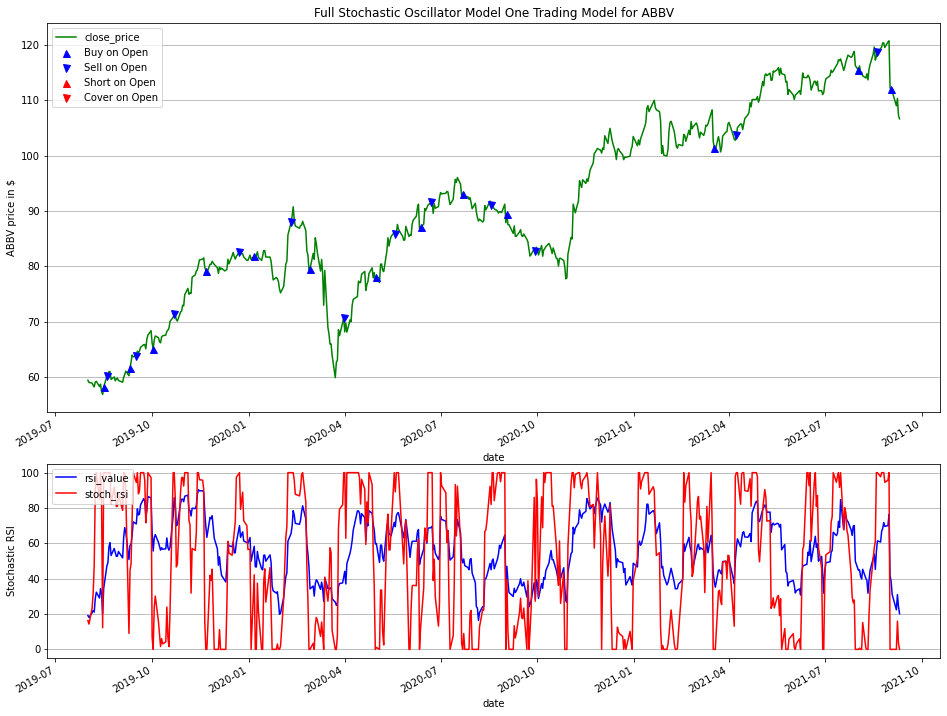

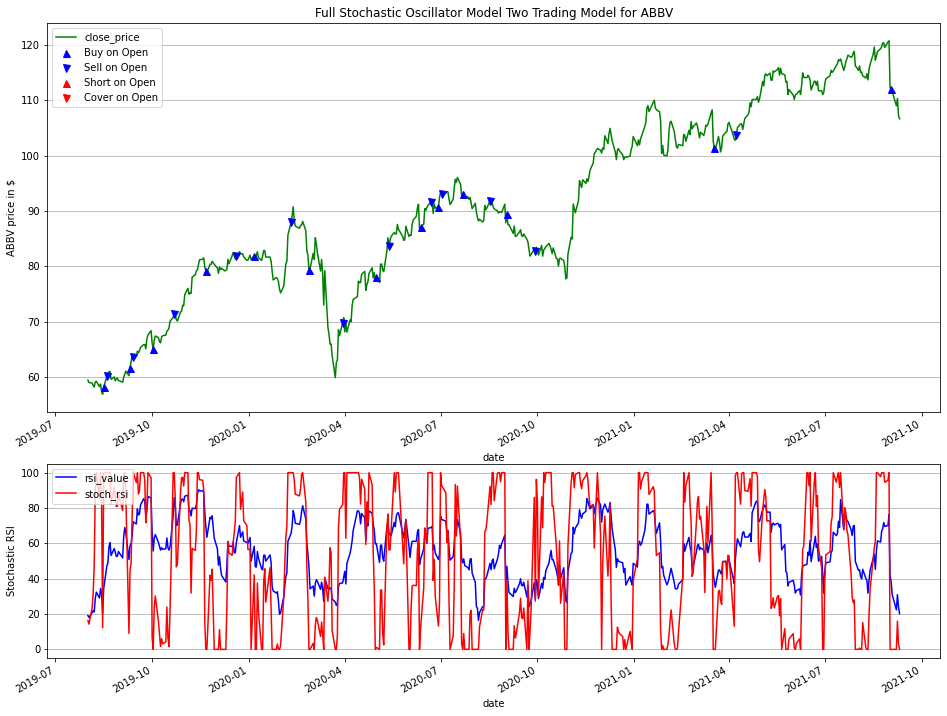

575 data points retrieved from the API call for stock: AMD

Generating the trading signals for model #1...

Generating the trading signals for model #2...

Calculating the positions for model #1...
The current status of the model is: Waiting to enter a position since 2021-05-24 


Calculating the positions for model #2...
The current status of the model is: Waiting to enter a position since 2021-06-29 

Processing the transactions for model #1...
Accumulated profit/loss for one share of stock with initial capital of $30.50 at the end of modeling period: $27.58
Accumulated return percentage based on the initial capital investment: 90.43%

Processing the transactions for model #2...
Accumulated profit/loss for one share of stock with initial capital of $30.50 at the end of modeling period: $26.35
Accumulated return percentage based on the initial capital investment: 86.41%

The entry point for the buy-and-hold model: $30.50 on 2019-08-01
The exit point for the buy-and-hold model: $106.99

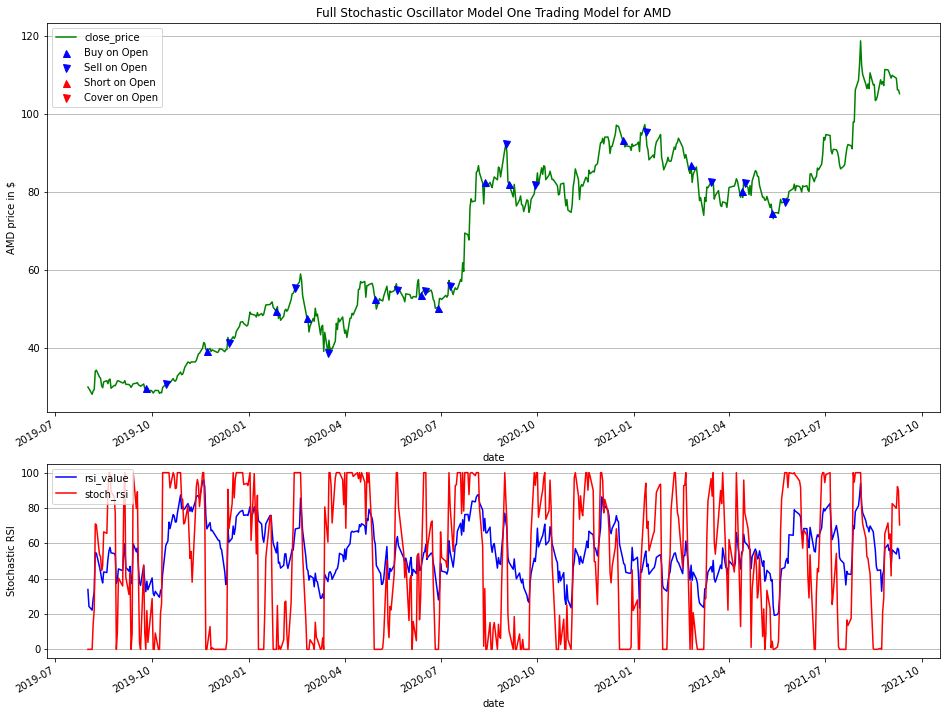

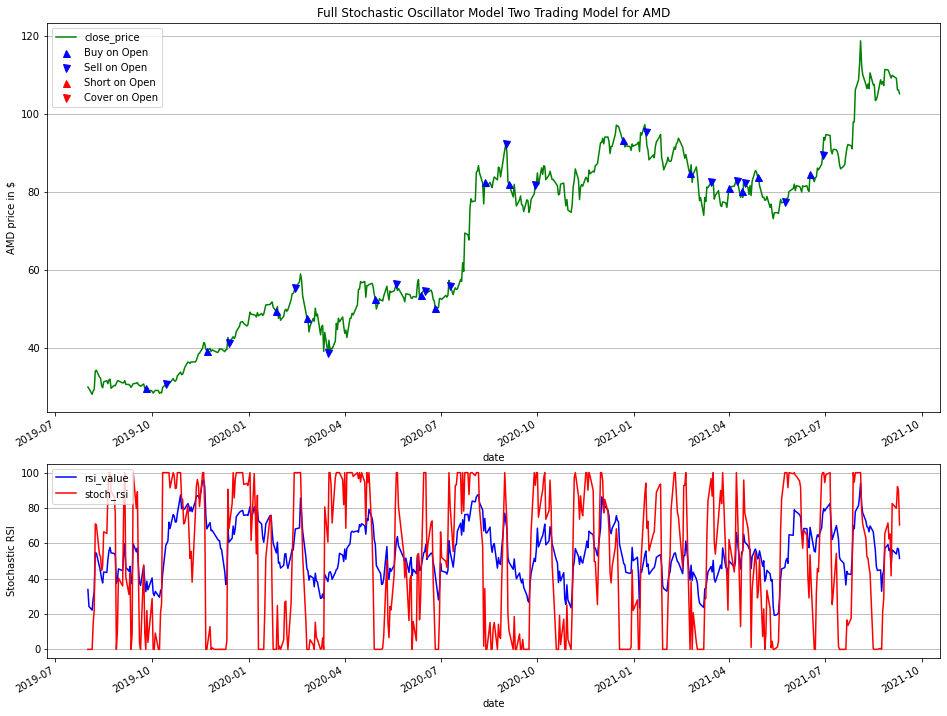

575 data points retrieved from the API call for stock: AMZN

Generating the trading signals for model #1...

Generating the trading signals for model #2...

Calculating the positions for model #1...
The current status of the model is: Waiting to enter a position since 2021-08-24 


Calculating the positions for model #2...
The current status of the model is: Waiting to enter a position since 2021-08-23 

Processing the transactions for model #1...
Accumulated profit/loss for one share of stock with initial capital of $1871.72 at the end of modeling period: $229.65
Accumulated return percentage based on the initial capital investment: 12.27%

Processing the transactions for model #2...
Accumulated profit/loss for one share of stock with initial capital of $1871.72 at the end of modeling period: $8.15
Accumulated return percentage based on the initial capital investment: 0.44%

The entry point for the buy-and-hold model: $1871.72 on 2019-08-01
The exit point for the buy-and-hold model: $

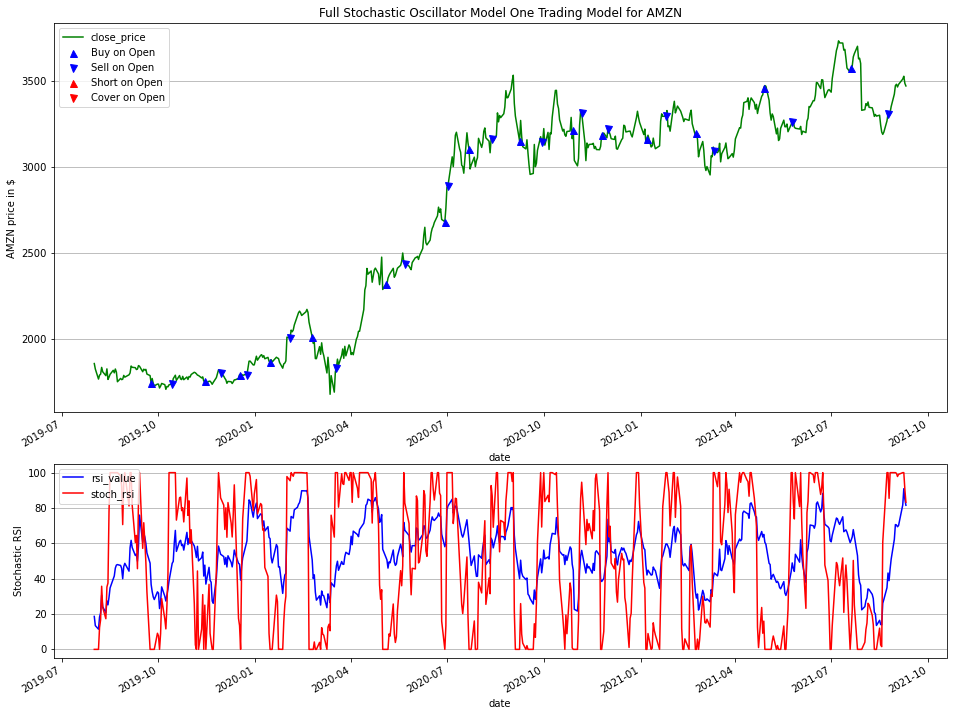

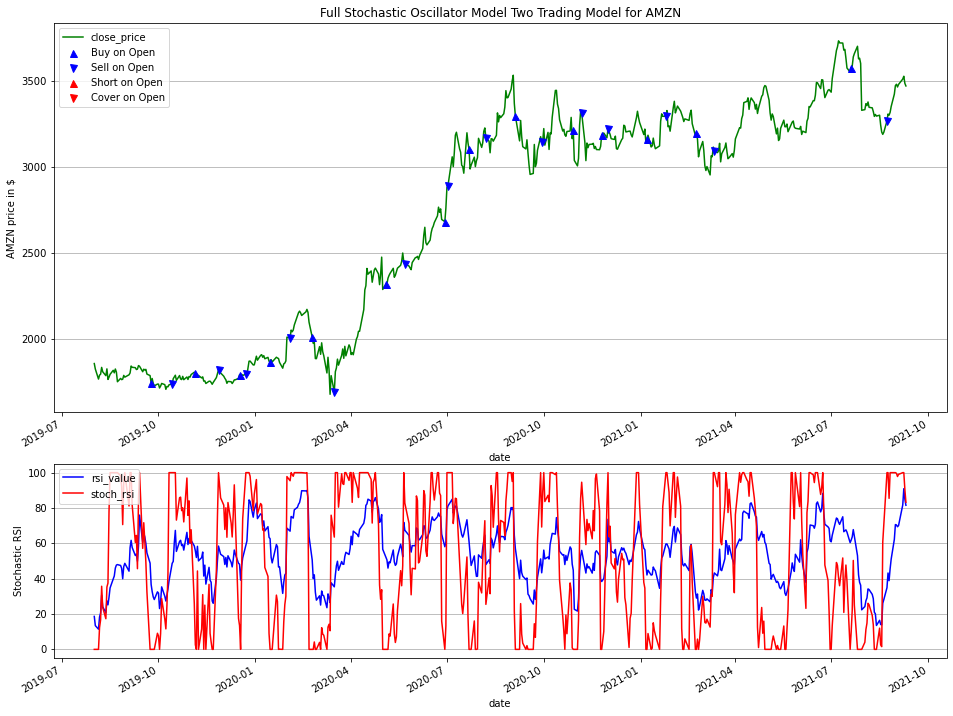

575 data points retrieved from the API call for stock: BA

Generating the trading signals for model #1...

Generating the trading signals for model #2...

Calculating the positions for model #1...
The current status of the model is: Waiting to enter a position since 2021-09-10 


Calculating the positions for model #2...
The current status of the model is: Waiting to enter a position since 2021-09-08 

Processing the transactions for model #1...
Accumulated profit/loss for one share of stock with initial capital of $335.88 at the end of modeling period: $-174.14
Accumulated return percentage based on the initial capital investment: -51.85%

Processing the transactions for model #2...
Accumulated profit/loss for one share of stock with initial capital of $335.88 at the end of modeling period: $-145.97
Accumulated return percentage based on the initial capital investment: -43.46%

The entry point for the buy-and-hold model: $335.88 on 2019-08-01
The exit point for the buy-and-hold model:

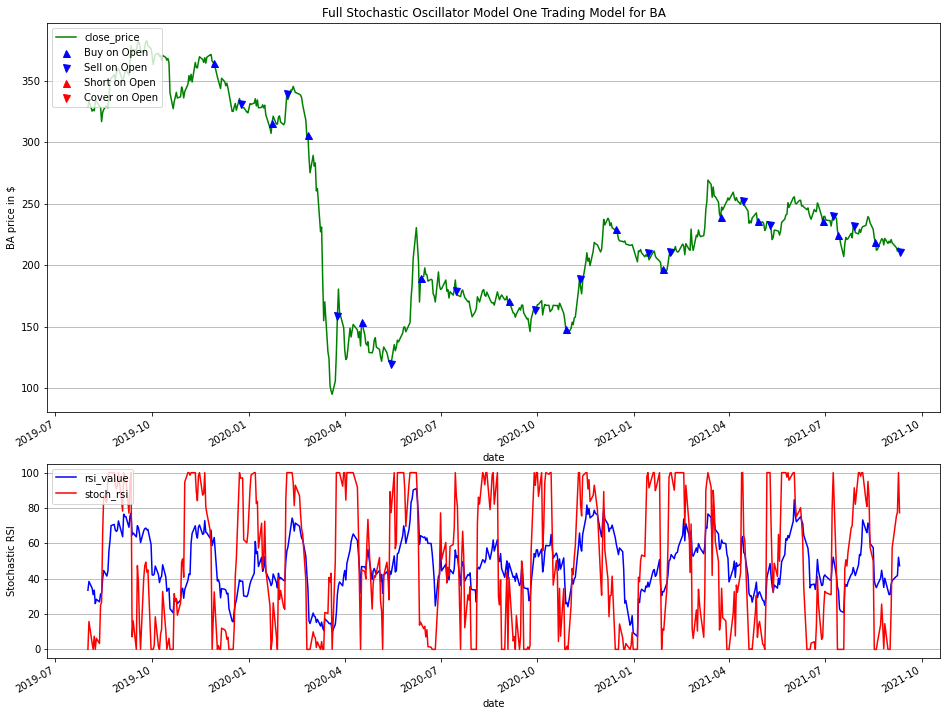

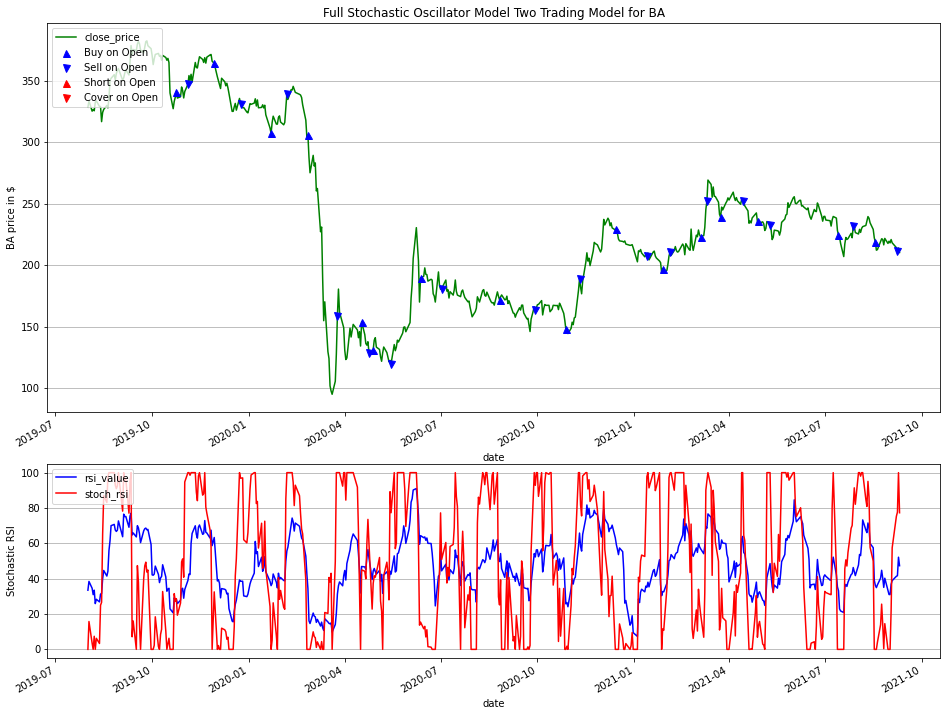

575 data points retrieved from the API call for stock: DIS

Generating the trading signals for model #1...

Generating the trading signals for model #2...

Calculating the positions for model #1...
The current status of the model is: Waiting to enter a position since 2021-08-09 


Calculating the positions for model #2...
The current status of the model is: Waiting to enter a position since 2021-08-09 

Processing the transactions for model #1...
Accumulated profit/loss for one share of stock with initial capital of $142.48 at the end of modeling period: $11.39
Accumulated return percentage based on the initial capital investment: 7.99%

Processing the transactions for model #2...
Accumulated profit/loss for one share of stock with initial capital of $142.48 at the end of modeling period: $-11.13
Accumulated return percentage based on the initial capital investment: -7.81%

The entry point for the buy-and-hold model: $142.48 on 2019-08-01
The exit point for the buy-and-hold model: $186

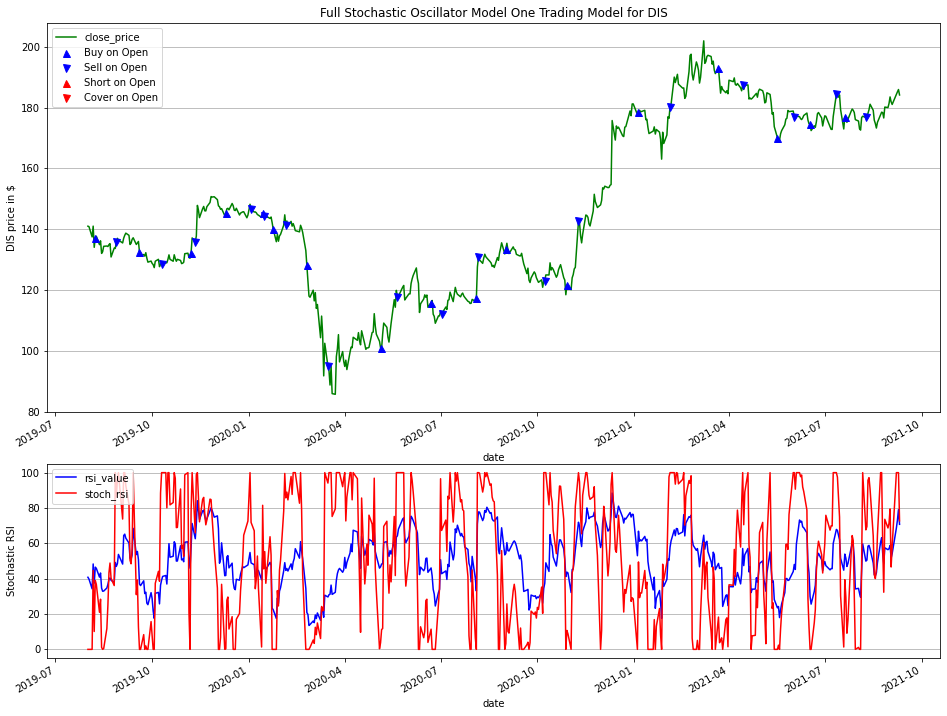

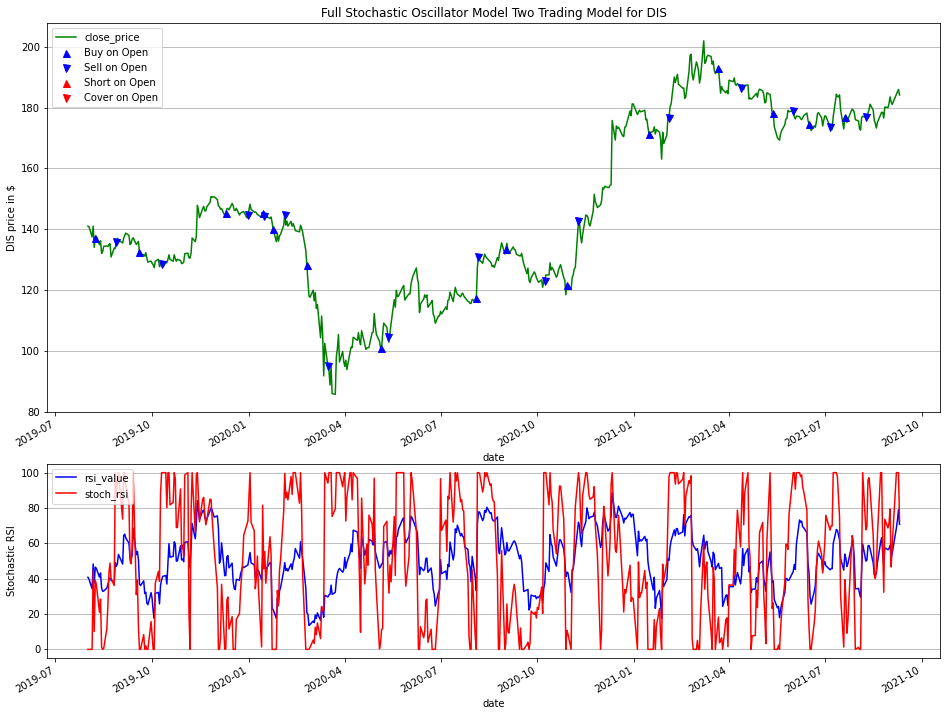

575 data points retrieved from the API call for stock: NFLX

Generating the trading signals for model #1...

Generating the trading signals for model #2...

Calculating the positions for model #1...
The current status of the model is: Waiting to enter a position since 2021-08-06 


Calculating the positions for model #2...
The current status of the model is: Waiting to enter a position since 2021-08-06 

Processing the transactions for model #1...
Accumulated profit/loss for one share of stock with initial capital of $324.25 at the end of modeling period: $45.80
Accumulated return percentage based on the initial capital investment: 14.13%

Processing the transactions for model #2...
Accumulated profit/loss for one share of stock with initial capital of $324.25 at the end of modeling period: $28.91
Accumulated return percentage based on the initial capital investment: 8.92%

The entry point for the buy-and-hold model: $324.25 on 2019-08-01
The exit point for the buy-and-hold model: $598

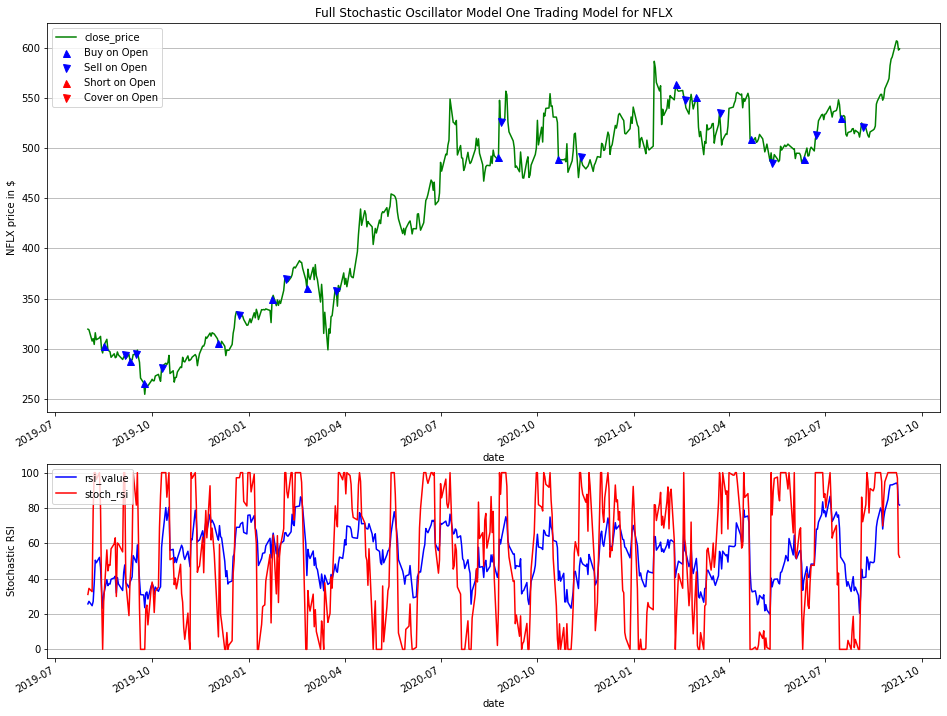

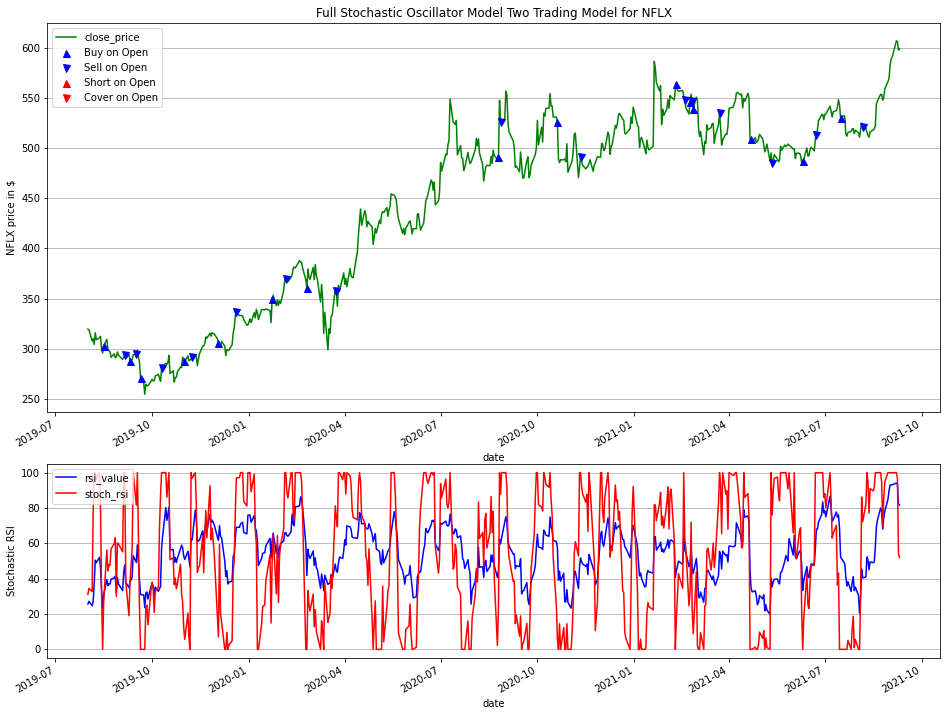

575 data points retrieved from the API call for stock: GOOGL

Generating the trading signals for model #1...

Generating the trading signals for model #2...

Calculating the positions for model #1...
The current status of the model is: Waiting to enter a position since 2021-08-30 


Calculating the positions for model #2...
The current status of the model is: Waiting to enter a position since 2021-08-25 

Processing the transactions for model #1...
Accumulated profit/loss for one share of stock with initial capital of $1217.63 at the end of modeling period: $650.25
Accumulated return percentage based on the initial capital investment: 53.40%

Processing the transactions for model #2...
Accumulated profit/loss for one share of stock with initial capital of $1217.63 at the end of modeling period: $784.41
Accumulated return percentage based on the initial capital investment: 64.42%

The entry point for the buy-and-hold model: $1217.63 on 2019-08-01
The exit point for the buy-and-hold mode

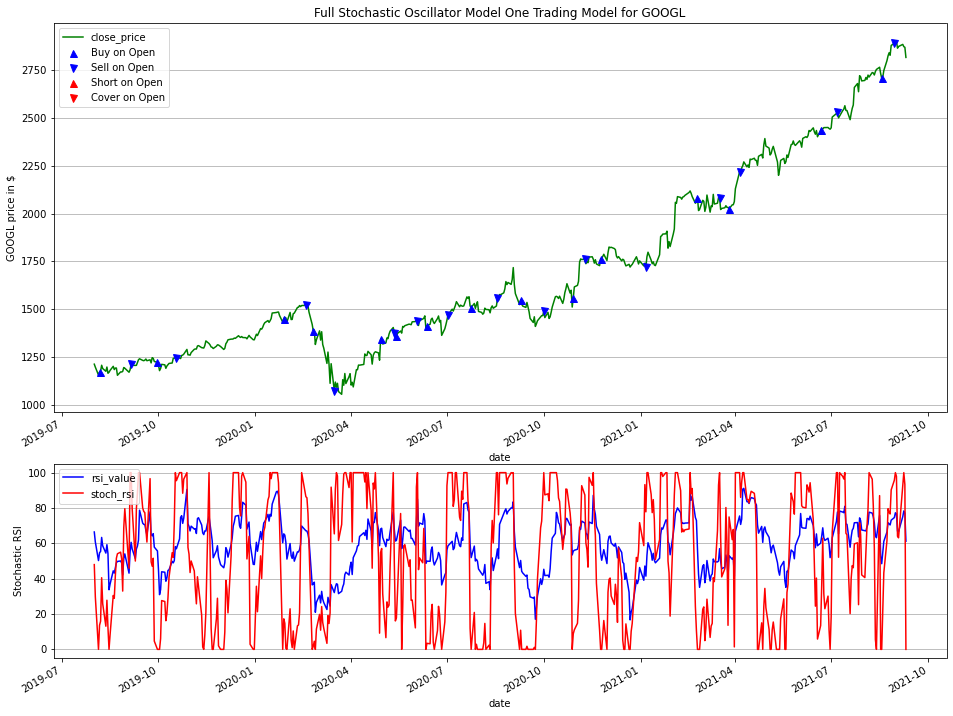

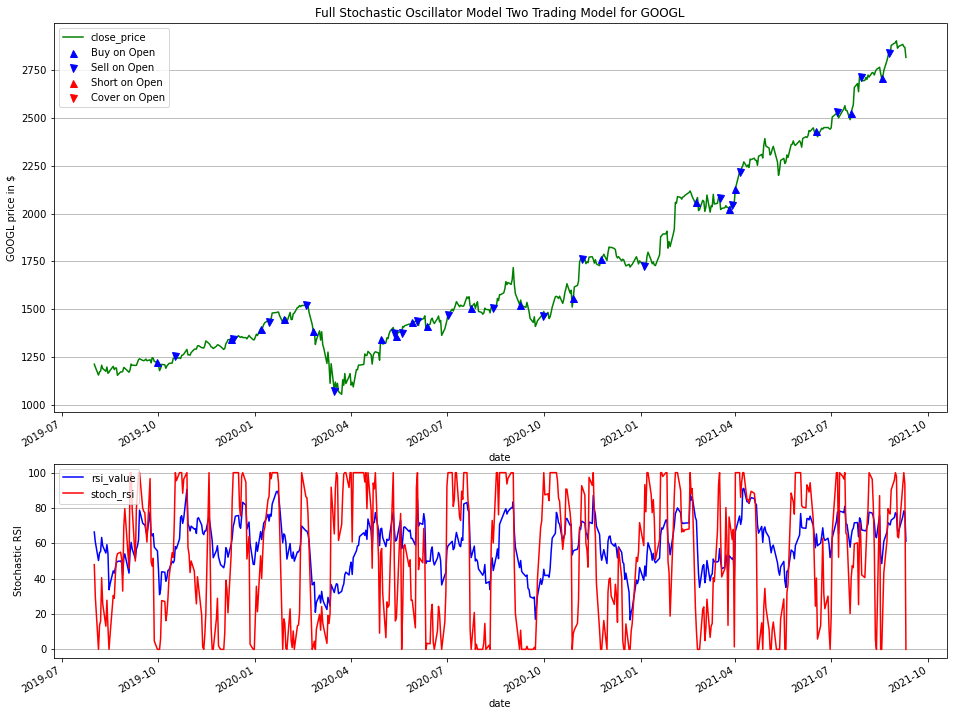

575 data points retrieved from the API call for stock: JPM

Generating the trading signals for model #1...

Generating the trading signals for model #2...

Calculating the positions for model #1...
The current status of the model is: Waiting to enter a position since 2021-08-06 


Calculating the positions for model #2...
The current status of the model is: Waiting to enter a position since 2021-09-10 

Processing the transactions for model #1...
Accumulated profit/loss for one share of stock with initial capital of $108.34 at the end of modeling period: $8.34
Accumulated return percentage based on the initial capital investment: 7.70%

Processing the transactions for model #2...
Accumulated profit/loss for one share of stock with initial capital of $108.34 at the end of modeling period: $-9.99
Accumulated return percentage based on the initial capital investment: -9.22%

The entry point for the buy-and-hold model: $108.34 on 2019-08-01
The exit point for the buy-and-hold model: $160.5

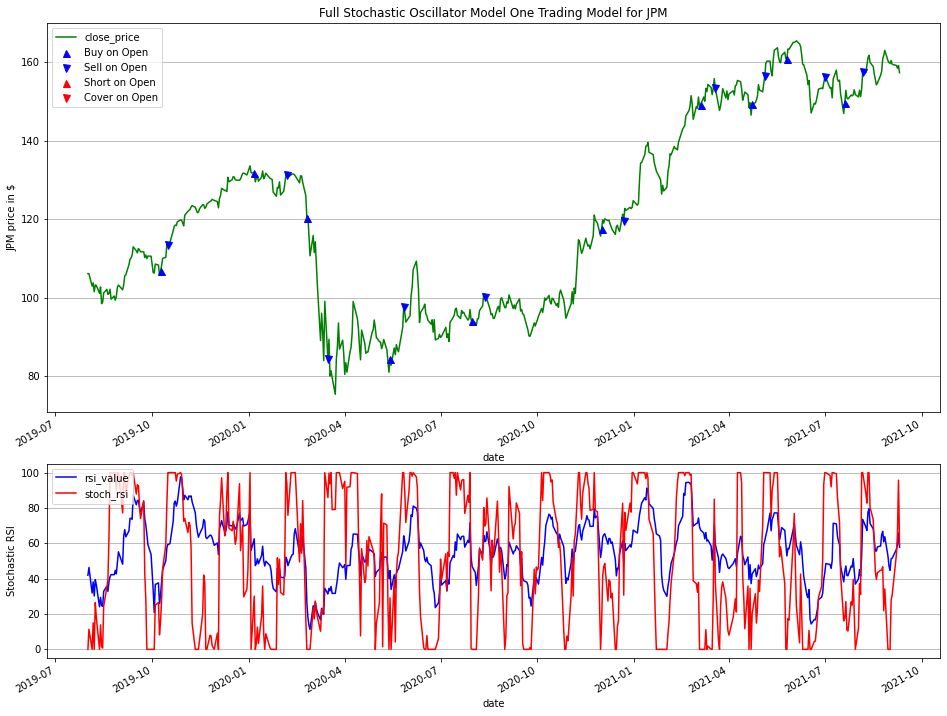

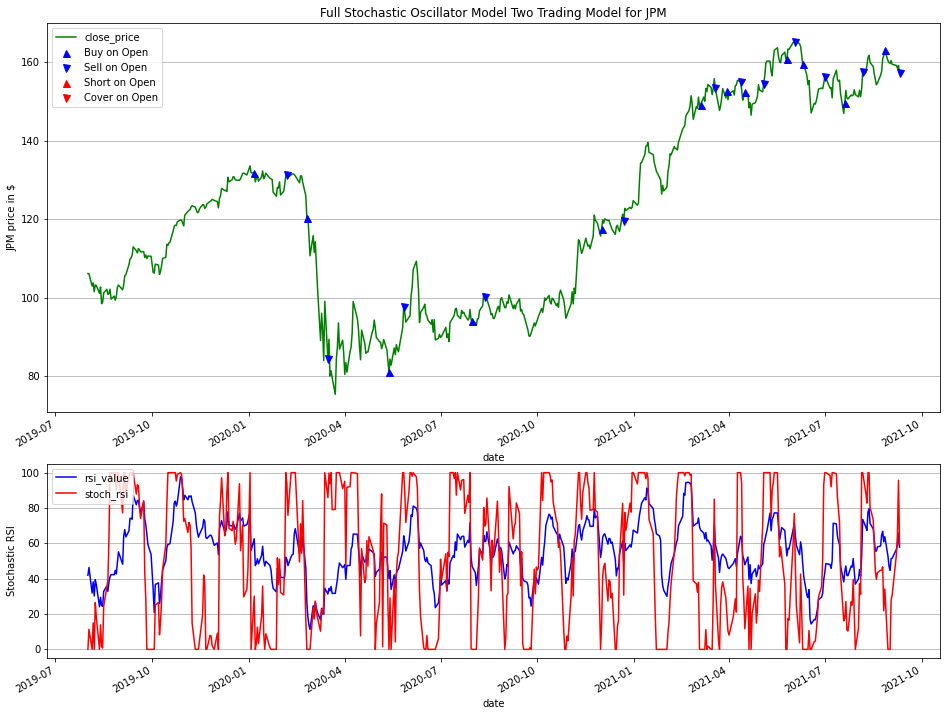

575 data points retrieved from the API call for stock: MSFT

Generating the trading signals for model #1...

Generating the trading signals for model #2...

Calculating the positions for model #1...
The current status of the model is: Holding a long position since 2021-09-10 


Calculating the positions for model #2...
The current status of the model is: Holding a long position since 2021-09-10 

Processing the transactions for model #1...
Accumulated profit/loss for one share of stock with initial capital of $133.77 at the end of modeling period: $45.33
Accumulated return percentage based on the initial capital investment: 33.88%

Processing the transactions for model #2...
Accumulated profit/loss for one share of stock with initial capital of $133.77 at the end of modeling period: $38.11
Accumulated return percentage based on the initial capital investment: 28.49%

The entry point for the buy-and-hold model: $133.77 on 2019-08-01
The exit point for the buy-and-hold model: $298.42 on 

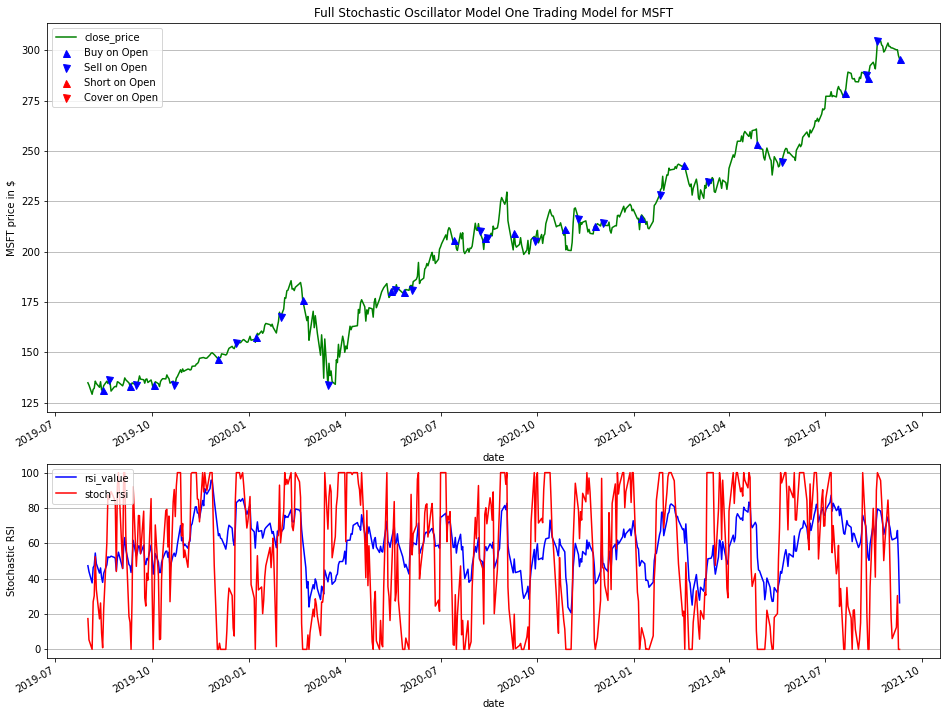

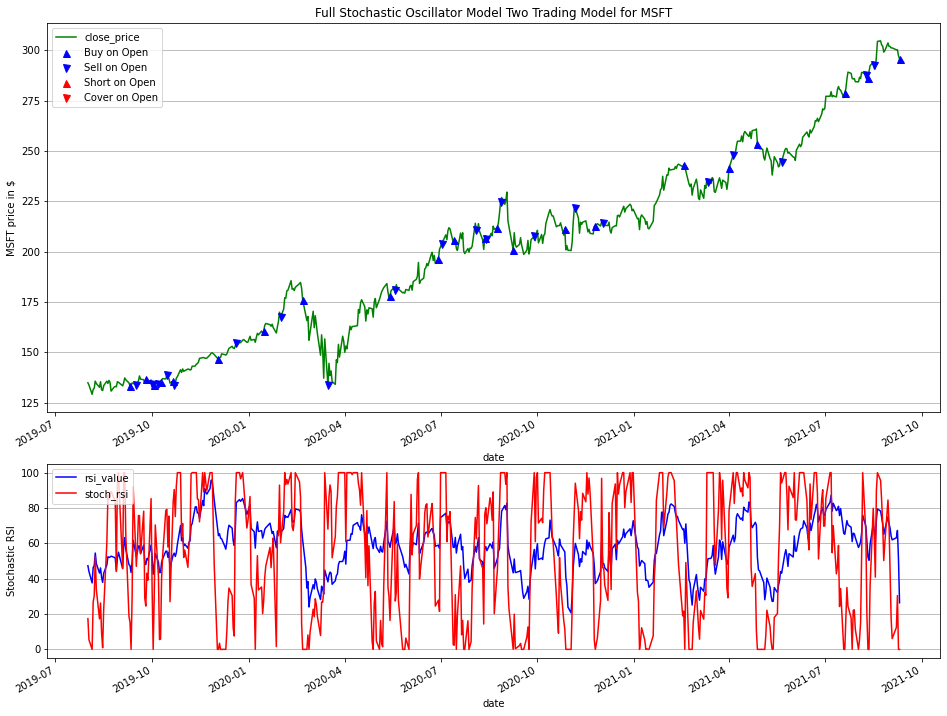

575 data points retrieved from the API call for stock: LUV

Generating the trading signals for model #1...

Generating the trading signals for model #2...

Calculating the positions for model #1...
The current status of the model is: Waiting to enter a position since 2021-08-25 


Calculating the positions for model #2...
The current status of the model is: Waiting to enter a position since 2021-07-02 

Processing the transactions for model #1...
Accumulated profit/loss for one share of stock with initial capital of $50.97 at the end of modeling period: $-2.44
Accumulated return percentage based on the initial capital investment: -4.78%

Processing the transactions for model #2...
Accumulated profit/loss for one share of stock with initial capital of $50.97 at the end of modeling period: $-3.64
Accumulated return percentage based on the initial capital investment: -7.14%

The entry point for the buy-and-hold model: $50.97 on 2019-08-01
The exit point for the buy-and-hold model: $49.38 

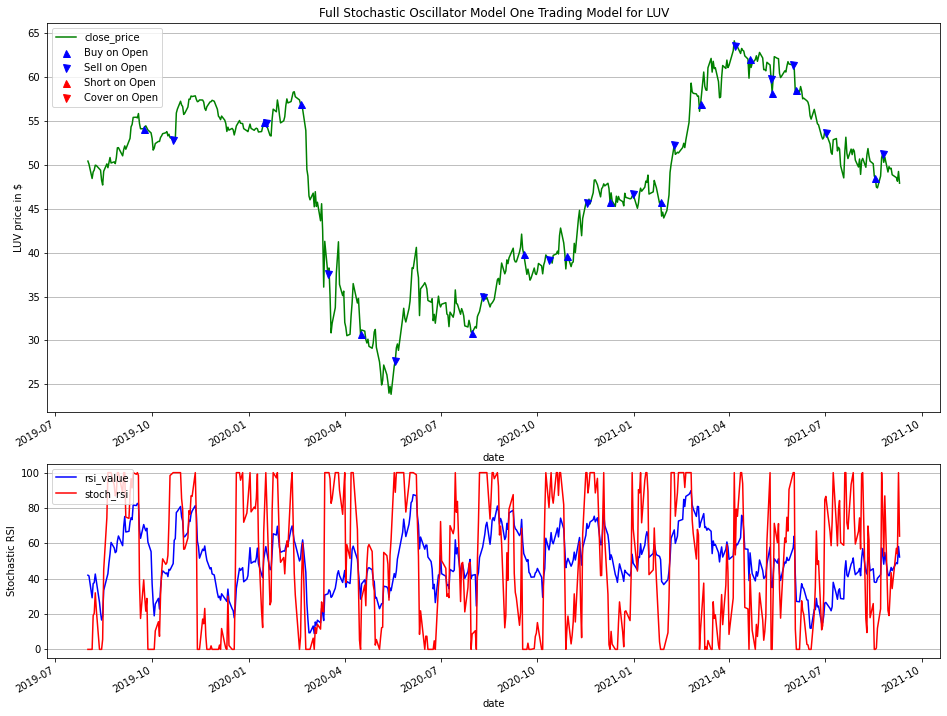

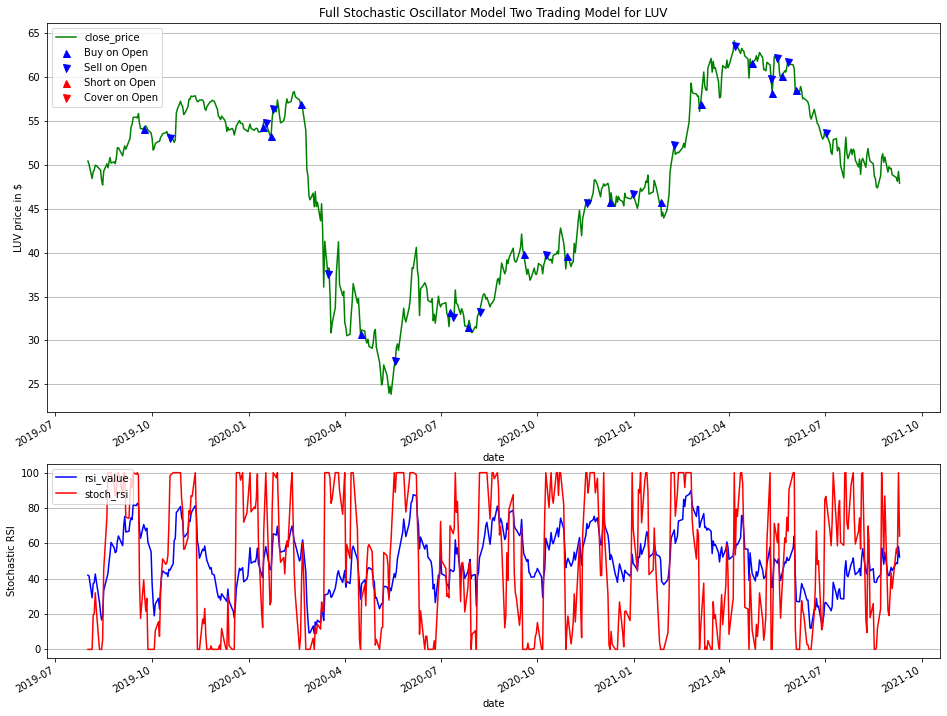

In [15]:
for symbol in stock_list:
    stock_signals_positions = {}
    stock_model_template = retrieve_stock_data(symbol)
    model_with_indicators = populate_indicators(stock_model_template)

    print('\nGenerating the trading signals for model #1...')
    tag_name = symbol + 'model1_signals'
    stock_signals_positions[tag_name] = populate_signals_model1(model_with_indicators)

    print('\nGenerating the trading signals for model #2...')
    tag_name = symbol + 'model2_signals'
    stock_signals_positions[tag_name] = populate_signals_model2(model_with_indicators)

    INITIAL_CAPITAL = stock_signals_positions[tag_name].at[stock_signals_positions[tag_name].index[0],'open_price']
    performance_values = evaluate_strategy_performance(symbol)
    performance_summary = performance_summary.append(performance_values, ignore_index=True)

In [16]:
print(performance_summary)

  Symbol  Buy_Hold_Return  BH_Return_PCT  Model1_Return_VAL  Model1_Return_PCT  Model1_MAX_Drawdown  Model2_Return_VAL  Model2_Return_PCT  Model2_MAX_Drawdown
0   ABBV          47.0558        77.8759            12.8722            21.3031             -37.9336             9.2828            15.3627             -36.9730
1    AMD          76.4900       250.7869            27.5800            90.4262             -43.1600            26.3550            86.4098             -44.9900
2   AMZN        1630.1100        87.0916           229.6500            12.2695           -1178.6300             8.1500             0.4354           -1332.0300
3     BA        -120.7165       -35.9407          -174.1406           -51.8466             -85.5541          -145.9686           -43.4590             -67.1721
4    DIS          43.8769        30.7945            11.3876             7.9922             -44.8593           -11.1272            -7.8095             -62.2491
5   NFLX         273.9100        84.4749      

In [17]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:01:15.096097
